**A Secure Model to Execute Queries Over Encrypted
Databases in the Cloud**

---

Modules -
1. Partitioning table(Original Table)
2. Partitioning tree
3. Encrypted table(AES)
4. Bits table(Encoding Algorithm)
5. Query Manager

Importing the csv file (i.e the table) from the drive folder

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/cs850/')

**Module 1: Partitioning Table(Original Table)**


---



In [ ]:
# create csv file for the table
import csv 
import pandas as pd 
fields_1 = ['id', 'name', 'ssn', 'rank', 'salary']  
  
rows_1 = [ ['01', 'Alice', '12701', 'secretary', '30000'],  
         ['02', 'Ryan', '25678', 'admin', '60000'],  
         ['03', 'Mark', '46932', 'secretary', '29000'],  
         ['04', 'John', '42213', 'manager', '55000']]  
    
filename = "employee.csv"
    
with open(filename, 'w') as csvfile: 
    csvwriter = csv.writer(csvfile) 
    csvwriter.writerow(fields_1)
    csvwriter.writerows(rows_1)
df = pd.read_csv('employee.csv')
display(df)

,id,name,ssn,rank,salary
0,1,Alice,12701,secretary,30000
1,2,Ryan,25678,admin,60000
2,3,Mark,46932,secretary,29000
3,4,John,42213,manager,55000


**Module 2: Partitioning tree**


---



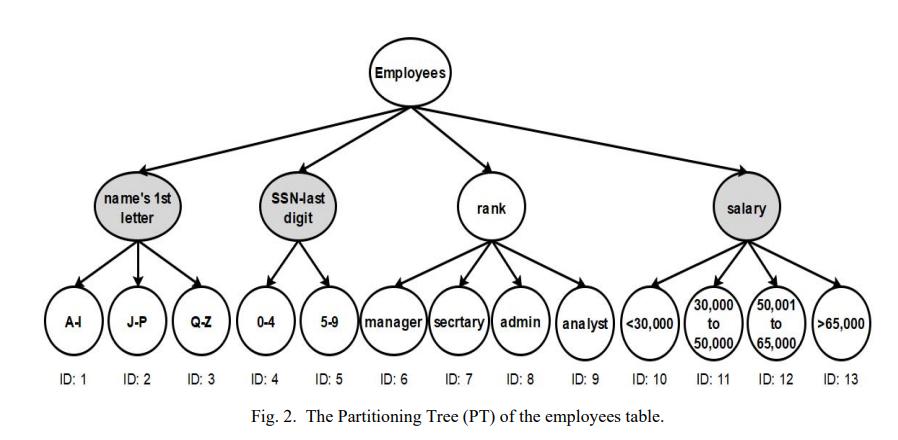

In [ ]:
from IPython.display import Image, display 
display(Image(filename='/content/drive/My Drive/cs850/partitioning_tree.png', embed=True))

**Module 3: Encrypted table(AES)**


---



In [ ]:
# installing Crypto library
!pip install Crypto
!pip install pycrypto

     |████████████████████████████████| 593kB 36.6MB/s 
     |████████████████████████████████| 450kB 20.6MB/s 
  Created wheel for pycrypto: filename=pycrypto-2.6.1-cp37-cp37m-linux_x86_64.whl size=499931 sha256=8a6b10e19c3b766396c4533c4ef2bbee39baef6fefe5e672dbd7eb26f451b34b
  Stored in directory: /root/.cache/pip/wheels/27/02/5e/77a69d0c16bb63c6ed32f5386f33a2809c94bd5414a2f6c196
Successfully built pycrypto


In [ ]:
# Encrypted table
import random, csv, os
import pandas as pd 
from Crypto.Cipher import AES

# column names
fields = ['id', 'name', 'ssn', 'rank', 'salary']

# table content
table = [ ['01', 'Alice', '12701', 'secretary', '30000'],  
         ['02', 'Ryan', '25678', 'admin', '60000'],  
         ['03', 'Mark', '46932', 'secretary', '29000'],  
         ['04', 'John', '42213', 'manager', '55000']] 


def encrypted_table(table):
  row_no = len(table)
  column_no = len(table[0])

  # define the key
  key = "00112233445566778899aabbccddeeff"
  
  # Initialization Vector - Purpose is to produce different encrypted data so that 
  # an attacker cannot get the key data or message data easily
  iv = b"\xe5kjQ\x10Z_\xe1\xc6\x06\xc9\x1bZ/'\xcd"
  aes = AES.new(key, AES.MODE_CBC, iv)

  # CBC mode - Cipher Block Chaining mode
  # each block is chained to the previous block
  
  # define the final encrypted table list
  encrypted_table_matrix = []
  for i in range(row_no):
    new_list = []
    for j in range(column_no):
      data = table[i][j]
      
      # padding with spaces if data is not multiple of 16 bytes
      if len(data)%16 != 0:
         data += ' ' * (16 - len(data) % 16)

      encd = aes.encrypt(data)
      new_list.append(encd)
    encrypted_table_matrix.append(new_list)

  # generate csv from the encrypted table matrix
  file_name = "encrypted_employee_table.csv"
  with open(file_name, 'w') as csvfile: 
      csvwriter = csv.writer(csvfile) 
      csvwriter.writerow(fields)
      csvwriter.writerows(encrypted_table_matrix)

encrypted_table(table)
df = pd.read_csv('encrypted_employee_table.csv')
display(df)

,id,name,ssn,rank,salary
0,b'\x9f{\xf8\xa8\xc1\xea\x14\x9d\x87\xdeN\xa3\x...,b'p\xce\xb4(\x16xF\xf9W\xba\x85q \xc2\n\xa3',b'\x93\x80\xce\xe8HS\xacl\x13\xdb\x1d_\xe2\x92...,b'gW\xfc\xde8\t\x83\xebk\x9a\x14\xef\xbf\x90D\...,b'\x19\xabc\xde\x9aj\x1e\x80\xd2\xe6\x9f\x97\x...
1,b'ID8\x80\xee6\n\xdbk\x08\xc3\x9f\x14ok\x82',b'C\x95\t@f\xd5\xe2I\xb2\xb6\xd8\xe1S\x99\xa5\...,"b""r\xcf\x7f\xaa\xef\xd6\xf4['B\x7f[\xe9\x9d\xb...","b"".\x1d\x97f\x1a(\xe3$\x01\x92\n*,e'\xd5""",b'\xc2\x8a\xd2\x90\x16\xdd\x8d;\x8d\xfc\xc7\xb...
2,b'\x86\x03\xfa-V\xa6\xbb\xf9R\xfa\x83\xc9a^8\xb6',b'\x94\xa4\xe8n\x0f\x02\xadX\xca\xfb\xfa\xdct\...,b'=8\xd6\x10.\x03\xa6\x11\x00\xec\xe2kq\r\x19r',b'\xe2\x80-Q\t\xe1\xbc\xf0I\x98\xa3\xcfI\x04\x...,b'\x8c\xbc\xb9\xd1{>\x04\xce&\x9fR`\xdb\xa2\xd...
3,b'\xb0\x94}\x03N7\xa3\xd6\x07\xe3\x83\xe5U4\xa...,b'\xaf\xe4ZR\x19\xb7T\xdeUN\x06\x16\xb6\t\xc15',b'\xf1\x01\xd5\xd3\xbe?\x8ax\xee\x82A\x16\xc8\...,b'U\x81U\x01\x10\xb1\x1f\xaa\xaa\x01\xb2\x9c\x...,b'\xbe\xc0;\xd2 0\xf3\x04M\xebM\x902 Ws'


**Module 4: Bits Table(Encoding Algorithm)**


---



In [ ]:
# Bits table - Encoding algorithm
# Bits table is a table which will be referred first when a user enters a query
# using this bits table, and the partitioning tree, we will go to the designated row
# in the encrypted table. 

# import pandas as pd
def bits_table():
  
  #define a vector V
  V = []

  filename_2 = "bits.csv"
  fields_2 = [1,2,3,4,5,6,7,8,9,10,11,12,13]

  # define rows of the bits table
  rows_2 = []

  # create all rows and store into rows_2
  for i in range(4):
    l = []
    for j in range(1,5):
      l.append(rows_1[i][j])
    rows_2.append(l)

  for i in range(4):
    # get the detail of each user
    name = rows_2[i][0]
    ssn = rows_2[i][1]
    rank = rows_2[i][2]
    salary = rows_2[i][3]
    # print(name, ssn, rank, salary)
    bit_vector = [0]*len(fields_2)

    # set the bit for name
    # there are 3 nodes for name
    # 1 -> A-I
    # 2 -> J-P
    # 3 -> Q-Z
    if (name[0] >= 'A' and name[0] <= 'I'):
      # set the bit for 1st field
      bit_vector[0] = 1
    elif (name[0] >= 'J' and name[0] <= 'P'):
      # set the bit for 2nd field
      bit_vector[1] = 1
    else:
      # set the bit for 3rd field
      bit_vector[2] = 1

    # set the bit for ssn field
    # there are 2 nodes for ssn
    # 4 -> 0-4
    # 5 -> 5-9
    if (int(ssn[-1]) >= 0 and int(ssn[-1]) <= 4):
      bit_vector[3] = 1
    else:
      bit_vector[4] = 1

    #set the bit for rank field
    #rank field is a non-range field
    # node id's - [6, 9]
    if (rank == "manager"):
      bit_vector[5] = 1
    elif (rank == "secretary"):
      bit_vector[6] = 1
    elif (rank == "admin"):
      bit_vector[7] = 1
    else:
      bit_vector[8] = 1

    # set the bit for salary field
    # 4 fields are there in salary field with node id's [10,13]
    sal = int(salary)
    if (sal < 30000):
      bit_vector[9] = 1
    elif (sal >= 30000 and sal <= 50000):
      bit_vector[10] = 1
    elif (sal >= 50001 and sal <= 65000):
      bit_vector[11] = 1
    else:
      bit_vector[12] = 1

    # add the bit vector to the final vector
    V.append(bit_vector)

  # Now add the vector to the bits.csv file
  with open(filename_2, 'w') as csvfile: 
    csvwriter = csv.writer(csvfile) 
    csvwriter.writerow(fields_2)
    csvwriter.writerows(V)

# sample call to bits_table
bits_table()
df = pd.read_csv('bits.csv')
display(df)

,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,0,0,1,0,0,1,0,0,0,1,0,0
1,0,0,1,0,1,0,0,1,0,0,0,1,0
2,0,1,0,1,0,0,1,0,0,1,0,0,0
3,0,1,0,1,0,1,0,0,0,0,0,1,0


**Module 5: Query Manager**


---



In [ ]:
import re
def query_manager(query):
  
  #define table_name, sensitive_columns and partitions
  table_name = 'employee'
  sensitive_col = ['name', 'ssn', 'rank', 'salary']
  partitions = {
      'name': ['A-I', 'J-P', 'Q-Z'],
      'ssn' : ['0-4', '5-9'],
      'rank' : ['manager', 'secretary', 'admin' ,'analyst'],
      'salary' : ['<30000', '30000-50000', '30001-65000', '>65000']
  }
  
  # extract the columns present in the query
  isSSN = False
  isRank = False
  isSalary = False

  if('ssn' in query):
    isSSN = True
  if('rank' in query):
    isRank = True
  if('salary' in query):
    isSalary = True

  print("Is ssn present? " + str(isSSN))
  print("Is rank present? " + str(isRank))
  print("Is salary present? " + str(isSalary))
  print("\n")

  # capture the strings present inside the quotes of the query string
  keywords = re.findall(r'"(.*?)"', query)
  print("Following are the searchable keywords in the query:")
  print(keywords)
  print("\n")

  # extract the labels
  print("Respective columns for the keywords:")
  if not isSSN and not isRank and isSalary:
    salary = keywords[0]
  if not isSSN and isRank and not isSalary:
    rank = keywords[0]
  if not isSSN and isRank and isSalary:
    rank = keywords[0]
    salary = keywords[1]
  if isSSN and not isRank and not isSalary:
    ssn = keywords[0]
  if isSSN and not isRank and isSalary:
    ssn = keywords[0]
    salary = keywords[1]
  if isSSN and isRank and not isSalary:
    ssn = keywords[0]
    rank = keywords[1]
  if isSSN and isRank and isSalary:
    ssn = keywords[0]
    rank = keywords[1]
    salary = keywords[2]
  if isSSN:
    print("SSN : " + str(ssn))
  if isRank:
    print("Rank : " + str(rank))
  if isSalary:
    print("Salary : " + str(salary))
  print("\n")

  # create id_dictionary
  id_dic = {}
  id_keys = 13
  id_values = ['A-I', 'J-P', 'Q-Z', '0-4', '5-9', 'manager', 'secretary', 'admin', 'analyst', '<30000', '30000-50000', '30001-65000', '>65000']
  for i in range(id_keys):
    id_dic[i+1] = id_values[i]

  
  # print the id_dictionary
  print("Following is the key-values pairs where key is id and value is table-values:")
  for key, value in id_dic.items():
    print(key, " -> ", value)
  print("\n")

  # generate the id_list which contains the id's which we require
  id_list = []
  # ssn
  if isSSN:
    if (int(ssn[-1]) >= 0 and int(ssn[-1]) <= 4):
      id_list.append(4)
    else:
      id_list.append(5)
  # rank
  if isRank:
    if (rank == "manager"):
      id_list.append(6)
    elif (rank == "secretary"):
      id_list.append(7)
    elif (rank == "admin"):
      id_list.append(8)
    else:
      id_list.append(9)
  # salary
  if isSalary:
    sal = int(salary)
    if (sal < 30000):
      id_list.append(10)
    elif (sal >= 30000 and sal <= 50000):
      id_list.append(11)
    elif (sal >= 50001 and sal <= 65000):
      id_list.append(12)
    else:
      id_list.append(13)

  # print the id_list
  print("Following are the id's we require to extract for the given query:")
  print(id_list)

  # iterate over the bits table and extract the rows which you want
  filename = 'bits.csv'
  column_names = ["id1","id2","id3","id4","id5","id6","id7","id8","id9","id10","id11","id12","id13"]
  df = pd.read_csv(filename, names=column_names)
  labels = []
  for i in range(len(id_list)):
    curr_id = "id"+str(id_list[i])
    label = df[curr_id].to_list()
    label.pop(0)
    labels.append(label)
  print(labels)

  # final row indexes
  row_indexes = [0,0,0,0]
  for i in range(len(labels)):
    for j in range(len(labels[0])):
      if labels[i][j] == 1:
        row_indexes[j] = 1
  print("\nFinal rows to extract:")
  print(row_indexes)

  # get the rows from the encrypted table
  column_names = ["id","name","ssn","rank","salary"]
  enc_table = "encrypted_employee__table.csv"
  df = pd.read_csv(enc_table, names=column_names)
  result_names = df["name"].to_list()
  result_names.pop(0)

  # remove the indices which we don't want
  remove_indices = []
  for i in range(len(row_indexes)):
    if row_indexes[i] == 0:
      remove_indices.append(i)
  result_names = [i for j, i in enumerate(result_names) if j not in remove_indices]

  # decrypt the encrypted results
  ans_list = []
  print("\nFinal name result:")
  key = "00112233445566778899aabbccddeeff"
  iv = b"\xe5kjQ\x10Z_\xe1\xc6\x06\xc9\x1bZ/'\xcd"
  aes = AES.new(key, AES.MODE_CBC, iv)
  for i in range(len(result_names)):
    val = result_names[i]
    decd = aes.decrypt(val+' '*(16 - len(val) % 16))
    ans_list.append(val)

  # print the final user query result
  print(ans_list)

In [ ]:
# sample query = select name from employees where rank = "admin" or salary = "20000";


# ask user for input query
query = input()

# call the query_manager function with the query
query_manager(query)

select name from employees where rank = "manager" or salary = "40000";
Is ssn present? False
Is rank present? True
Is salary present? True


Following are the searchable keywords in the query:
['manager', '40000']


Respective columns for the keywords:
Rank : manager
Salary : 40000


Following is the key-values pairs where key is id and value is table-values:
1  ->  A-I
2  ->  J-P
3  ->  Q-Z
4  ->  0-4
5  ->  5-9
6  ->  manager
7  ->  secretary
8  ->  admin
9  ->  analyst
10  ->  <30000
11  ->  30000-50000
12  ->  30001-65000
13  ->  >65000


Following are the id's we require to extract for the given query:
[6, 11]
[[0, 0, 0, 1], [1, 0, 0, 0]]

Final rows to extract:
[1, 0, 0, 1]

Final name result:
['Alice', 'John']
